/Users/kevinxiao/Documents/Programming/QGC related stuff/va_parallel_sim/variational circuit


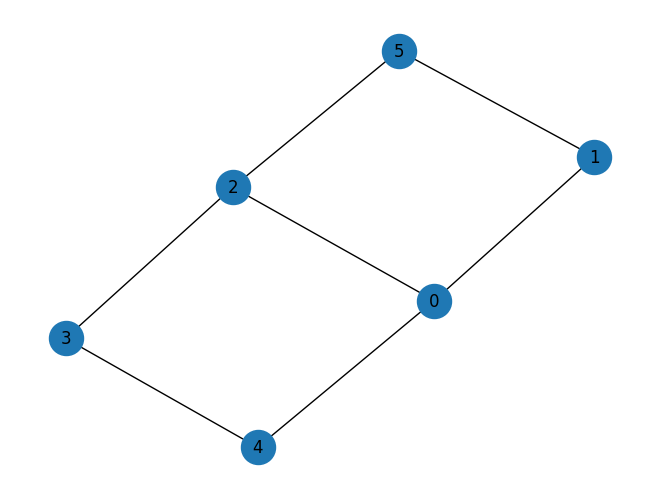

In [183]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np

n = 6

graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
# edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 4, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0)]
edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 4, 1.0), (1, 5, 1.0), (2, 3, 1.0), (3, 4, 1.0), (2, 5, 1.0)]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

import os
print(os.getcwd())  # Confirm

In [184]:
from qiskit.quantum_info import SparsePauliOp
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list

max_cut_paulis = build_max_cut_paulis(graph)

print(max_cut_paulis)

cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

[('IIIIZZ', 1.0), ('IIIZIZ', 1.0), ('IZIIIZ', 1.0), ('ZIIIZI', 1.0), ('IIZZII', 1.0), ('IZZIII', 1.0), ('ZIIZII', 1.0)]
Cost Function Hamiltonian: SparsePauliOp(['IIIIZZ', 'IIIZIZ', 'IZIIIZ', 'ZIIIZI', 'IIZZII', 'IZZIII', 'ZIIZII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


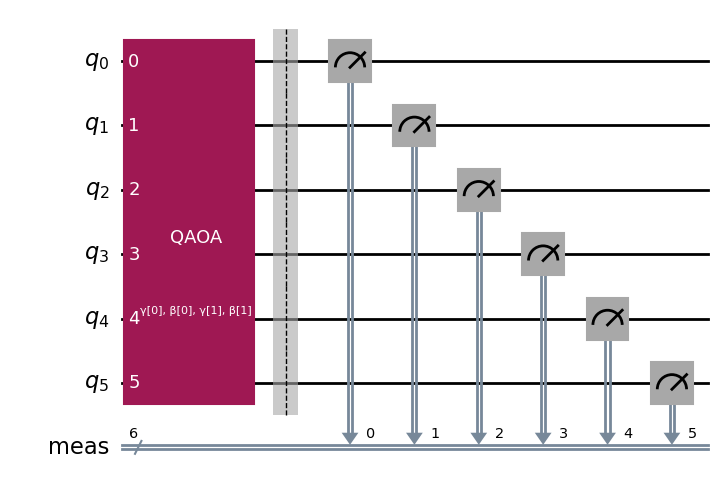

In [185]:
from qiskit.circuit.library import QAOAAnsatz

circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
circuit.measure_all()

circuit.draw('mpl')

In [186]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])])

QasmSimulator('qasm_simulator')


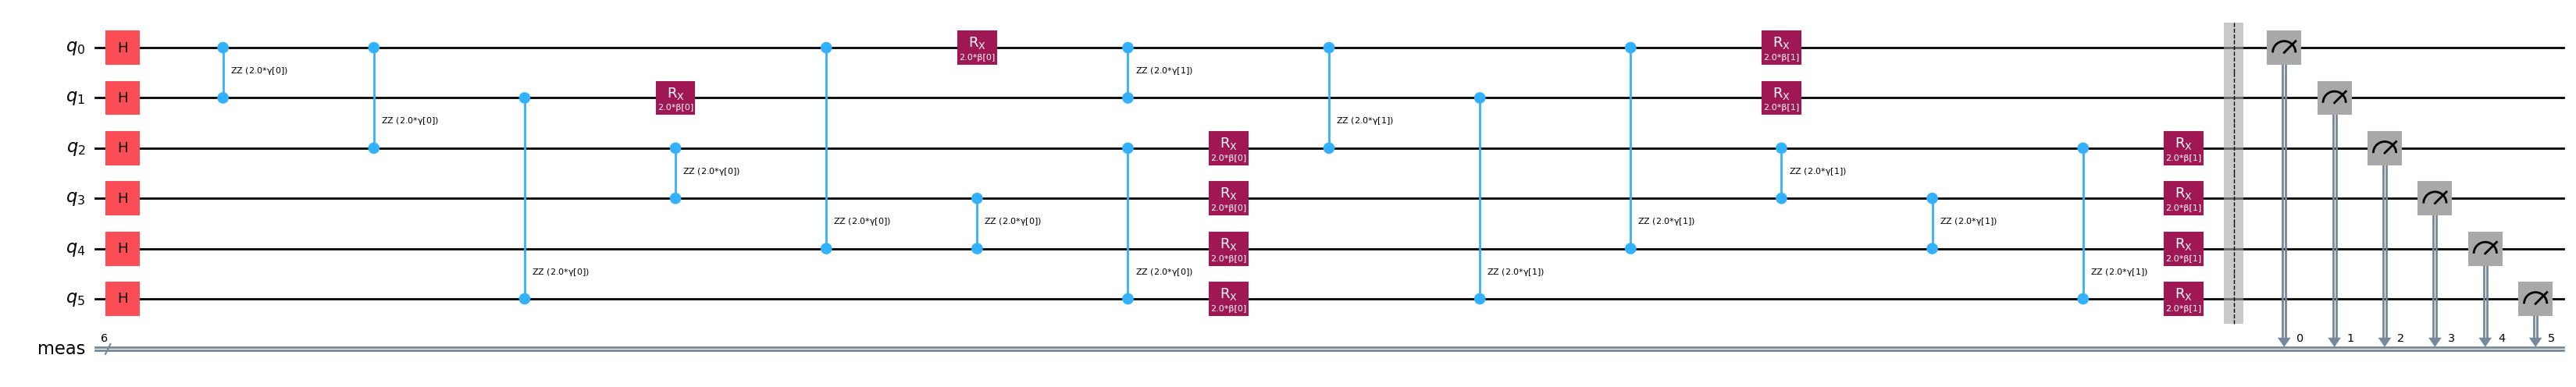

In [187]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import *


# QiskitRuntimeService.save_account(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>", overwrite=True, set_as_default=True)
backend = backend = Aer.get_backend('qasm_simulator')
print(backend)

# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=backend)

candidate_circuit = pm.run(circuit)
candidate_circuit.draw('mpl', fold=False, idle_wires=False)

In [188]:
initial_gamma = np.pi / 8
initial_beta = np.pi/ 4
init_params = [initial_gamma, initial_beta, initial_gamma, initial_beta]

In [189]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    
    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)


    return cost

In [190]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from scipy.optimize import minimize

objective_func_vals = [] # Global variable
with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, cost_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-2,
    )
    print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.2917082917082916
       x: [ 1.176e+00  1.461e+00  3.713e-01  6.973e-01]
    nfev: 28
   maxcv: 0.0


/opt/homebrew/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/opt/homebrew/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/opt/homebrew/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have n

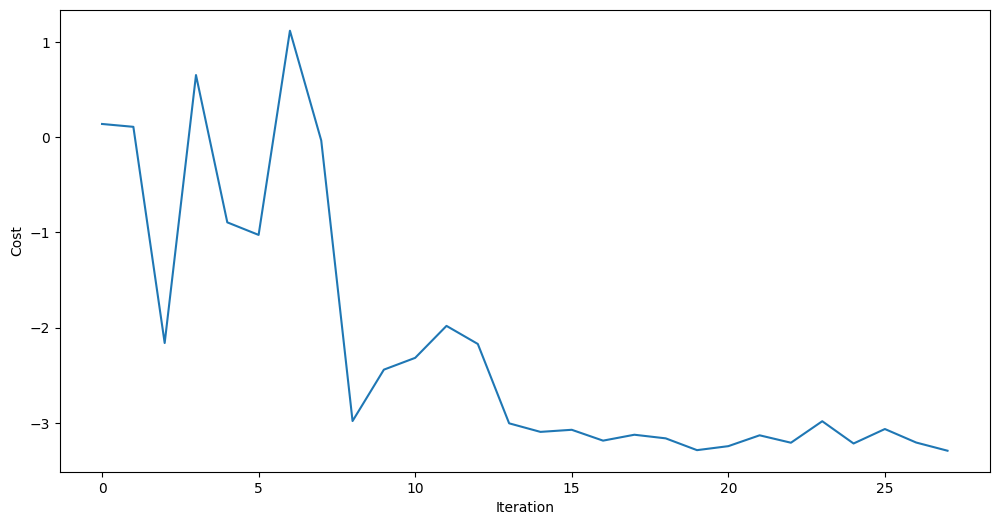

In [191]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

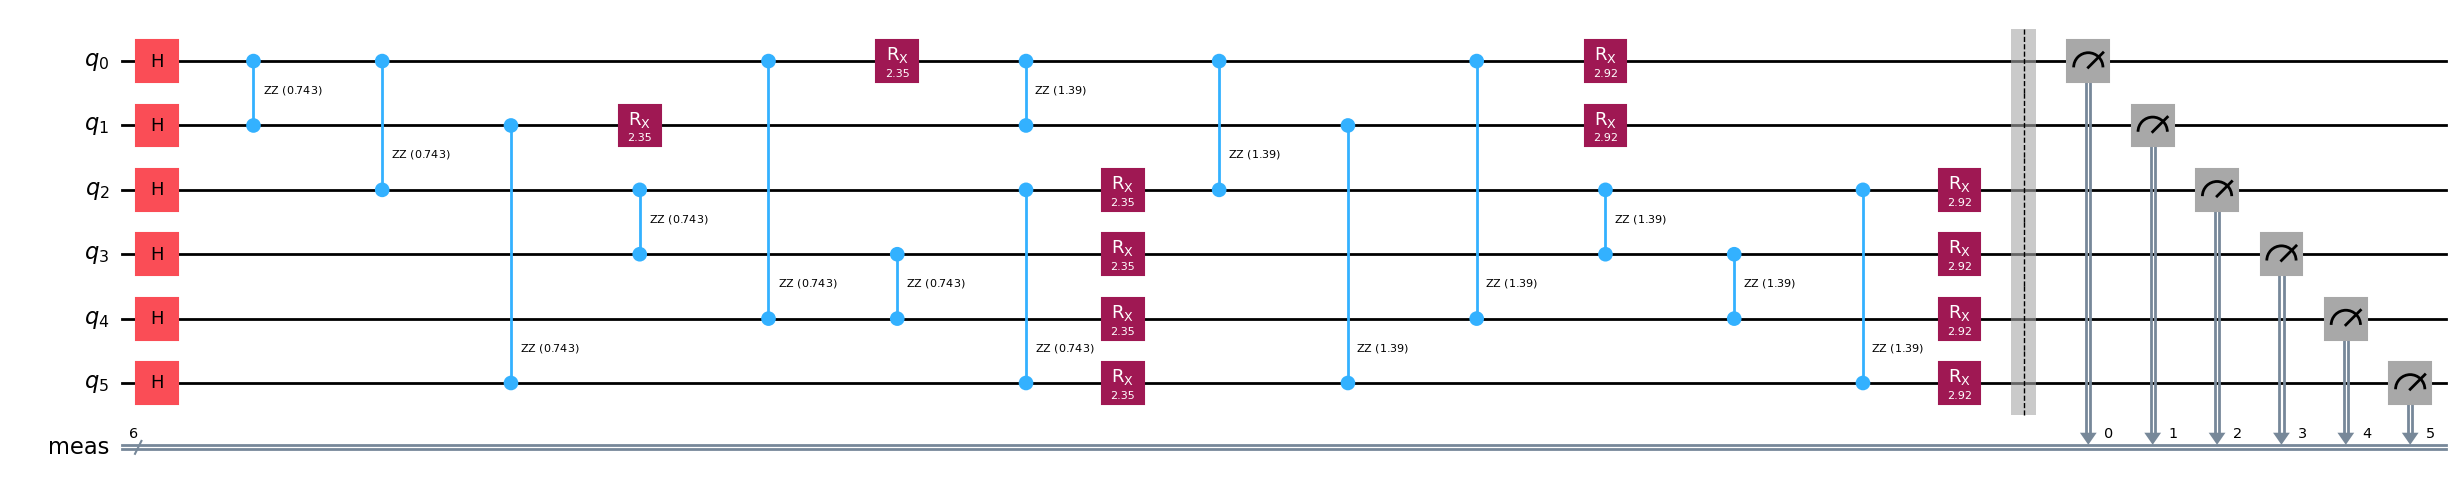

In [192]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw('mpl', fold=False, idle_wires=False)

In [193]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

{52: 0.063, 50: 0.0164, 22: 0.1362, 57: 0.019, 11: 0.0546, 30: 0.0188, 33: 0.022, 19: 0.0124, 49: 0.0594, 5: 0.0352, 7: 0.0147, 8: 0.0024, 41: 0.1342, 35: 0.0038, 14: 0.0593, 56: 0.0154, 58: 0.033, 48: 0.0086, 61: 0.0019, 26: 0.0166, 20: 0.0217, 37: 0.0165, 23: 0.0098, 42: 0.0147, 13: 0.0143, 54: 0.0178, 25: 0.0032, 40: 0.0095, 44: 0.0124, 15: 0.0087, 18: 0.0105, 21: 0.0149, 12: 0.0005, 43: 0.019, 6: 0.0204, 39: 0.0011, 3: 0.0011, 31: 0.0021, 32: 0.0026, 17: 0.0014, 47: 0.0022, 53: 0.0086, 10: 0.0087, 9: 0.0195, 45: 0.0104, 55: 0.0029, 38: 0.0032, 51: 0.0007, 28: 0.0026, 0: 0.001, 16: 0.0017, 29: 0.0006, 36: 0.0009, 27: 0.0008, 60: 0.0011, 63: 0.0009, 46: 0.0007, 4: 0.0001, 59: 0.0006, 1: 0.0006, 34: 0.0008, 2: 0.0014, 24: 0.0006, 62: 0.0003}


/opt/homebrew/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


In [194]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(graph))
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [0, 1, 1, 0, 1, 0]


/var/folders/wt/rjn2snfs5m9drm826w9lxljw0000gn/T/ipykernel_11113/3823459478.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.get_children()[int(p)].set_color("tab:purple")


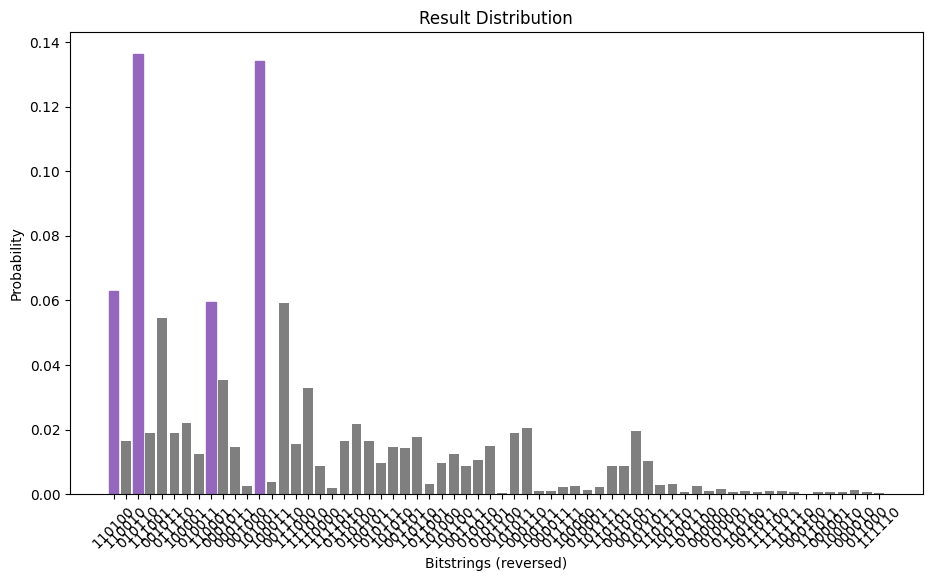

In [195]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
plt.show()

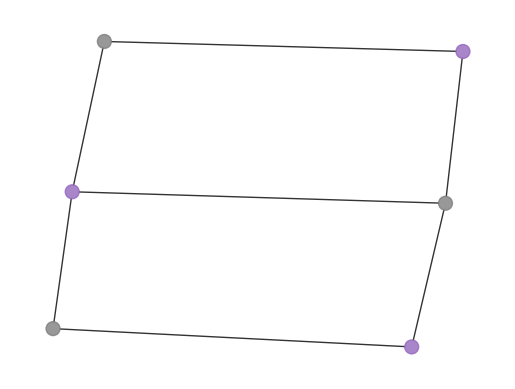

In [196]:
# auxiliary function to plot graphs
def plot_result(G, x):
    colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    pos, default_axes = rx.spring_layout(G), plt.axes(frameon=True)
    rx.visualization.mpl_draw(G, node_color=colors, node_size=100, alpha=0.8, pos=pos)


plot_result(graph, most_likely_bitstring)